Data loaded successfully!

Training set size: 359615 (from 301 tickers)
Validation set size: 121907 (from 101 tickers)
Test set size: 120831 (from 101 tickers)

--- Training XGBoost Classifier ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Training LightGBM Classifier ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 21826, number of negative: 337789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 359615, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

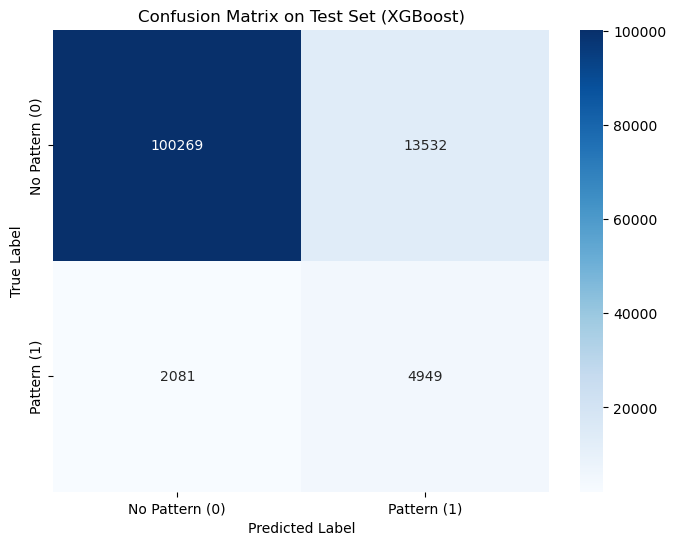

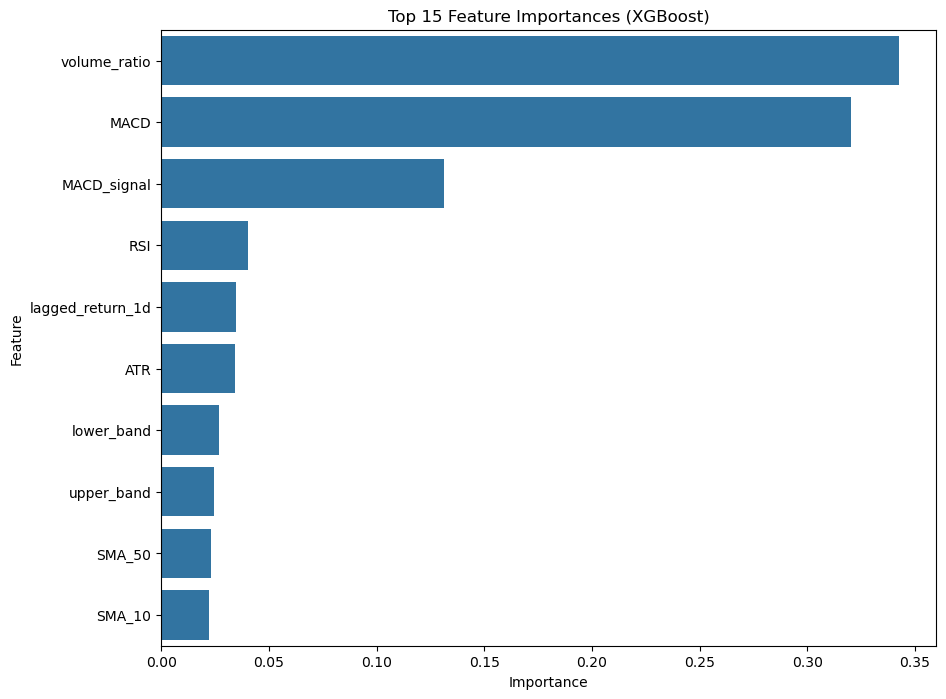


Best XGBoost model saved as 'best_xgboost_model.json'.


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('processed_stock_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'processed_stock_data.csv' not found. Please run the data_processing notebook first.")
    exit()

df.dropna(inplace=True)

# --- IMPROVED DATA SPLITTING BY TICKER ---
tickers = df['Ticker'].unique()

# Shuffle the tickers to ensure a random distribution
np.random.seed(42)
np.random.shuffle(tickers)

# Split tickers into train, validation, and test sets
train_tickers = tickers[:int(0.6 * len(tickers))]
val_tickers = tickers[int(0.6 * len(tickers)):int(0.8 * len(tickers))]
test_tickers = tickers[int(0.8 * len(tickers)):]

# Create datasets based on the ticker splits
train_df = df[df['Ticker'].isin(train_tickers)]
val_df = df[df['Ticker'].isin(val_tickers)]
test_df = df[df['Ticker'].isin(test_tickers)]

# Separate features (X) and target (y) for each dataset
X_train = train_df.select_dtypes(include=['float64', 'int64', 'bool']).drop(columns=['cup_and_handle'], errors='ignore')
y_train = train_df['cup_and_handle']
X_val = val_df.select_dtypes(include=['float64', 'int64', 'bool']).drop(columns=['cup_and_handle'], errors='ignore')
y_val = val_df['cup_and_handle']
X_test = test_df.select_dtypes(include=['float64', 'int64', 'bool']).drop(columns=['cup_and_handle'], errors='ignore')
y_test = test_df['cup_and_handle']

print(f"\nTraining set size: {len(X_train)} (from {len(train_tickers)} tickers)")
print(f"Validation set size: {len(X_val)} (from {len(val_tickers)} tickers)")
print(f"Test set size: {len(X_test)} (from {len(test_tickers)} tickers)")

# --- MODEL 1: XGBoost Classifier ---
print("\n--- Training XGBoost Classifier ---")
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

param_distributions_xgb = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'scale_pos_weight': [1, 2, 5]
}

f1_scorer = make_scorer(f1_score)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=20,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)
best_xgb_model = random_search_xgb.best_estimator_

# --- MODEL 2: LightGBM Classifier ---
print("\n--- Training LightGBM Classifier ---")
lgbm_model = lgb.LGBMClassifier(random_state=42)

param_distributions_lgbm = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5),
    'class_weight': ['balanced', None]
}

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions_lgbm,
    n_iter=20,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_lgbm.fit(X_train, y_train)
best_lgbm_model = random_search_lgbm.best_estimator_

# --- EVALUATION AND COMPARISON ---
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name):
    """Helper function to evaluate a model on validation and test sets."""
    print(f"\n--- {model_name} Performance ---")
    
    # Validation Set
    y_pred_val = model.predict(X_val)
    precision_val = precision_score(y_val, y_pred_val, zero_division=0)
    recall_val = recall_score(y_val, y_pred_val, zero_division=0)
    f1_val = f1_score(y_val, y_pred_val, zero_division=0)
    print(f"Validation F1-Score: {f1_val:.4f}")
    
    # Test Set
    y_pred_test = model.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test, zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, zero_division=0)
    print(f"Test F1-Score: {f1_test:.4f}")
    
    return precision_test, recall_test, f1_test

# Evaluate both models
precision_xgb, recall_xgb, f1_xgb = evaluate_model(best_xgb_model, X_val, y_val, X_test, y_test, "XGBoost")
precision_lgbm, recall_lgbm, f1_lgbm = evaluate_model(best_lgbm_model, X_val, y_val, X_test, y_test, "LightGBM")

print("\n--- Final Model Comparison on Test Set ---")
print("Model            | Precision | Recall  | F1-Score")
print("-" * 45)
print(f"XGBoost          | {precision_xgb:.4f}  | {recall_xgb:.4f}  | {f1_xgb:.4f}")
print(f"LightGBM         | {precision_lgbm:.4f}  | {recall_lgbm:.4f}  | {f1_lgbm:.4f}")

# --- CONFUSION MATRIX AND FEATURE IMPORTANCE FOR BEST MODEL ---
# Assuming XGBoost is likely the best model, we'll use it for visualization.
print("\n--- Visualizations for Best Model (XGBoost) ---")
cm = confusion_matrix(y_test, best_xgb_model.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pattern (0)', 'Pattern (1)'], yticklabels=['No Pattern (0)', 'Pattern (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set (XGBoost)')
plt.show()

feature_importances = best_xgb_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

best_xgb_model.save_model('best_xgboost_model.json')
print("\nBest XGBoost model saved as 'best_xgboost_model.json'.")
